In [1]:
# pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance

In [ ]:
import pandas as pd
import pandas_ta as ta
import numpy as np
from numpy import NaN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import warnings

import os
import yfinance as yf
warnings.filterwarnings("ignore")


In [ ]:
def deepseek_absa_dataprocess(path):
  absa = pd.read_parquet(path)

  absa_date = absa[["date","tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa","cybersecurity_absa"]]
  absa_date = absa_date.groupby([absa_date['date'].dt.date], as_index=False).mean()

  absa_date['date'] = pd.to_datetime(absa_date['date'], format='%Y-%m-%d')

  # Extract only the date part (ignore the time)
  absa['date'] = absa['date'].dt.date
  absa_date['date'] = absa_date['date'].dt.date

  # Count the number of entries per day
  entries_per_day = absa.groupby('date').size()

  # Map the counts back to the original dataset
  absa['entries_per_day'] = absa['date'].map(entries_per_day)

  # Fill missing values with 0, if necessary
  absa_date['entries_per_day'] = absa['entries_per_day'].fillna(0)

  sentiment_columns = [
    'tanalysis_absa',
    'economy_absa',
    'regulation_absa',
    'technology_absa',
    'adoption_absa',
    'cybersecurity_absa'
  ]

  # 2. Compute the average sentiment for each entry (row) by averaging across the sentiment columns
  absa_date['Average Sentiment'] = absa_date[sentiment_columns].mean(axis=1)
  absa_date['Average Sentiment'].fillna(0, inplace=True)
  absa_date['Sentiment_MA3'] = absa_date['Average Sentiment'].rolling(window=3, min_periods=1).mean()
  absa_date['Sentiment_MA7'] = absa_date['Average Sentiment'].rolling(window=7, min_periods=1).mean()
  absa_date['Sentiment_MA14'] = absa_date['Average Sentiment'].rolling(window=14, min_periods=1).mean()

  return absa_date


In [ ]:
def MutualInfo(df):
  X = df.drop(["target","date"], axis=1)
  y = df["target"]
  mi_scores = mutual_info_regression(X, y)
  mi_scores = pd.Series(mi_scores, index=X.columns)
  mi_scores.sort_values(ascending=False, inplace=True)
  print(mi_scores)

In [ ]:
def run_backtest(df):

  # ------------------ Data check ------------------
  # Check for NA values
  if df.isnull().values.any():
    raise ValueError("DataFrame contains NA values")

  # Check for required column: 'signal'
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # if 'return_forward_1d' is not present, it will be fetched automatically
  if 'return_forward_1d' not in df.columns:
    df = concat_return(df)

  # ------------------ Average Return & Sharpe ------------------
  # Calculate daily returns
  df['strategy_return'] = df['signal'] * df['return_forward_1d']

  # Overall Geometric Annual Return and Sharpe Ratio
  num_days = len(df)
  annual_return = (1 + df['strategy_return']).prod()**(365/num_days) - 1

  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(365)
  overall_sharpe = annual_return / annual_std

  print(f"Overall Annual Return: {round(annual_return*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # Count the number of winning vs losing days
  winning_trades = (df['strategy_return'] > 0).sum()
  losing_trades = (df['strategy_return'] < 0).sum()
  if losing_trades > 0:
    win_loss_ratio = winning_trades / losing_trades
  else:
    win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  print("Win/Loss Ratio:", round(win_loss_ratio, 2))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, return_forward_1d) / Var(return_forward_1d)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward_1d'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(return_forward_1d)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward_1d'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** 365 - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(365/len(subdf)) - 1,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(365),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward_1d'])[1,1]
      )
      * subdf['return_forward_1d'].mean()
    ) * 365
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return'] / yearly_data['yearly_std']
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward_1d']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()

def fetch_bitcoin_return_daily():
  price_df = yf.download("BTC-USD", interval="1d", start='2021-01-01', end='2025-01-02')
  price_df = price_df.xs('Close', level='Price', axis=1)
  price_df.columns = ['price']
  price_df['daily_return'] = price_df['price'].pct_change()
  price_df['return_forward_1d'] = price_df['daily_return'].shift(-1)
  price_df.drop(columns=['price', 'daily_return'], inplace=True)
  price_df = price_df[:-1]
  price_df.to_parquet('btc_return_daily.parquet')

def concat_return(df):
  file_path = "btc_return_daily.parquet"
  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    fetch_bitcoin_return_daily()
    df_btc_return = pd.read_parquet(file_path)
  merged_df = pd.merge(df, df_btc_return, left_index=True, right_index=True, how='inner')
  return merged_df

def generate_signals(predicted_returns, threshold=0):
    signals = np.where(predicted_returns*100 > threshold, 1, -1)  # 1 for buy, -1 for sell
    return signals

def gen_target(data,btc_price):
  data["target"] = btc_price["Close"].pct_change().shift(-1)
  data["target"] = data["target"].fillna(value=0)
  data['entries_per_day'] = data['entries_per_day'].fillna(0)
  return data


In [ ]:
data = deepseek_absa_dataprocess("/content/drive/MyDrive/3b.cryptonews_absa.parquet")
btc_price = pd.read_parquet("/content/drive/MyDrive/BTCUSDT.parquet.gzip")

data = data [:-1]
data = gen_target(data,btc_price)
data.head()



,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
0,2021-01-01,0.635294,0.052941,-0.020588,0.014706,0.208824,-0.008824,43.0,0.147059,0.147059,0.147059,0.147059,0.097050
1,2021-01-02,0.769767,0.011628,-0.006977,0.002326,0.069767,0.000000,34.0,0.141085,0.144072,0.144072,0.144072,0.025536
2,2021-01-03,0.697436,-0.007692,0.007692,0.020513,0.189744,0.000000,34.0,0.151282,0.146475,0.146475,0.146475,-0.030647
3,2021-01-04,0.071212,0.006061,-0.010606,0.027273,0.122727,0.000000,34.0,0.036111,0.109493,0.118884,0.118884,0.061297
4,2021-01-05,0.490769,0.061538,0.032308,0.038462,0.240000,0.000000,34.0,0.143846,0.110413,0.123877,0.123877,0.083059


In [ ]:
#Missing Target
target_col = "Target"

train_startdate = pd.to_datetime("2021-01-01").date()
train_enddate = pd.to_datetime("2022-12-31").date()

# Training: 2021-01-01 to 2022-12-31
train_data = data[(data['date'] >= train_startdate) & (data['date'] <= train_enddate)]

val_startdate = pd.to_datetime("2023-01-01").date()
val_enddate = pd.to_datetime("2023-12-31").date()

# Validation: 2023-01-01 to 2023-12-31
validation_data = data[(data['date'] >= val_startdate) & (data['date'] <= val_enddate)]

test_startdate = pd.to_datetime("2024-01-01").date()
test_enddate = pd.to_datetime("2024-12-31").date()

# Test: 2024-01-01 to 2024-12-31
test_data = data[(data['date'] >= test_startdate) & (data['date'] <= test_enddate)]

features = ["tanalysis_absa","economy_absa","regulation_absa","technology_absa","adoption_absa","cybersecurity_absa","entries_per_day", "Average Sentiment", "Sentiment_MA3", "Sentiment_MA7", "Sentiment_MA14"]
target_col = 'target'

test_data

,date,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,entries_per_day,Average Sentiment,Sentiment_MA3,Sentiment_MA7,Sentiment_MA14,target
1095,2024-01-01,-0.054651,-0.009302,0.043023,0.011628,0.239535,-0.003488,40.0,0.037791,0.073442,0.104670,0.116813,0.017369
1096,2024-01-02,0.076444,0.014667,0.113778,0.028000,0.343556,-0.024444,40.0,0.092000,0.075742,0.112723,0.113771,-0.046759
1097,2024-01-03,0.020532,-0.003422,0.028517,0.017490,0.228897,-0.028517,40.0,0.043916,0.057902,0.095449,0.112613,0.030479
1098,2024-01-04,0.077626,-0.004566,0.005023,0.057078,0.398174,-0.007763,40.0,0.087595,0.074504,0.075567,0.108802,-0.000136
1099,2024-01-05,0.006557,-0.003825,0.068852,0.057377,0.298907,0.008743,40.0,0.072769,0.068093,0.073801,0.102210,-0.004005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2024-12-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,0.010615
1457,2024-12-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,-0.016388
1458,2024-12-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.0,0.000000,0.000000,0.000000,0.000000,-0.010094
1459,2024-12-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.008448


In [ ]:
MutualInfo(data)

tanalysis_absa        0.029529
regulation_absa       0.027838
economy_absa          0.015637
cybersecurity_absa    0.014550
Sentiment_MA14        0.010557
Sentiment_MA7         0.000388
technology_absa       0.000000
adoption_absa         0.000000
entries_per_day       0.000000
Average Sentiment     0.000000
Sentiment_MA3         0.000000
dtype: float64


In [ ]:
feature_cols =["tanalysis_absa","economy_absa","regulation_absa","cybersecurity_absa"
, "Sentiment_MA7", "Sentiment_MA14"]
target_col = "target"

X_train = train_data[feature_cols]
y_train = train_data[target_col]

# Validation Data
X_val = validation_data[feature_cols]
y_val = validation_data[target_col]

# Test Data
X_test = test_data[feature_cols]
y_test = test_data[target_col]



In [ ]:
nan_counts_before = data.isna().sum()
print(nan_counts_before)

date                  0
tanalysis_absa        0
economy_absa          0
regulation_absa       0
technology_absa       0
adoption_absa         0
cybersecurity_absa    0
entries_per_day       0
Average Sentiment     0
Sentiment_MA3         0
Sentiment_MA7         0
Sentiment_MA14        0
target                0
dtype: int64


In [ ]:
# Example: Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_rf_reg = grid_search.best_estimator_
best_rf_reg.fit(X_train, y_train)


Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestRegressor(max_depth=5, random_state=42)

In [ ]:
importances = best_rf_reg.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)


              Feature  Importance
4       Sentiment_MA7    0.230721
5      Sentiment_MA14    0.199557
0      tanalysis_absa    0.193805
1        economy_absa    0.156127
2     regulation_absa    0.138247
3  cybersecurity_absa    0.081543


In [ ]:
#Evaluate Model by Validation
y_pred_val = best_rf_reg.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')


Validation Set Metrics:
MSE: 0.000726
R-squared: -0.3566


Overall Annual Return: 55.95%
Overall Annual Sharpe Ratio: 1.2648
Maximum Drawdown: -25.26 %
Win/Loss Ratio: 1.05
Alpha: 0.2162
Beta: 0.3227

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.559488    0.442354     0.322658      0.195752       1.264798


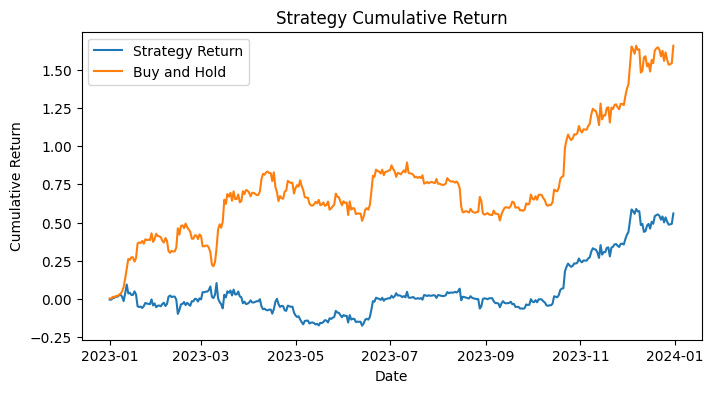

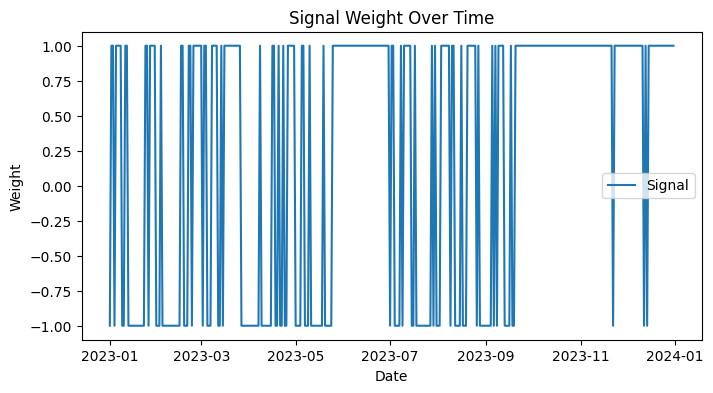

In [ ]:
# Apply to validation data
validation_data['Predicted Close %'] = y_pred_val
validation_data['signal'] = generate_signals(validation_data['Predicted Close %'])

validation_data.index = pd.to_datetime(validation_data.index)

validation_data.index = validation_data.date

run_backtest(validation_data)

# XGB

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 10, 100]
}

xgb = XGBRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Print progress
    n_jobs=-1  # Use all available CPU cores
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)
best_xgb_reg = grid_search.best_estimator_


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best Score (Negative MSE): -0.0014280726280223874


In [ ]:
#Evaluate Model by Validation
y_pred_val = best_xgb_reg.predict(X_val)

mse = mean_squared_error(y_val, y_pred_val)
# mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f'Validation Set Metrics:')
print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')
print(f'R-squared: {r2:.4f}')

Validation Set Metrics:
MSE: 0.000581
R-squared: -0.0852


Overall Annual Return: 32.61%
Overall Annual Sharpe Ratio: 0.7365
Maximum Drawdown: -37.33 %
Win/Loss Ratio: 1.06
Alpha: 0.0178
Beta: 0.3377

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2023       0.326139    0.442817     0.337715      0.017598       0.736509


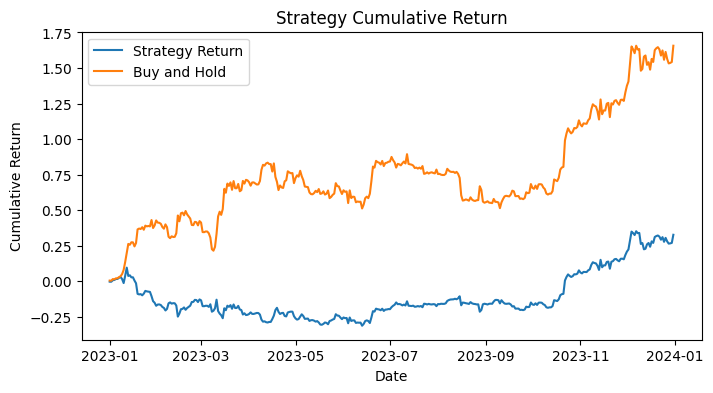

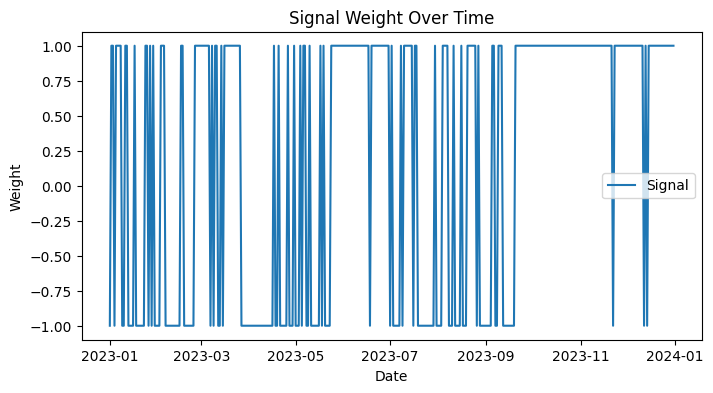

In [ ]:
validation_data['Predicted Close %'] = y_pred_val
validation_data['signal'] = generate_signals(validation_data['Predicted Close %'])
run_backtest(validation_data)

# Testing

Overall Annual Return: 175.17%
Overall Annual Sharpe Ratio: 3.2894
Maximum Drawdown: -26.31 %
Win/Loss Ratio: 1.18
Alpha: 0.9904
Beta: 0.5165

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.751691    0.532531     0.516493      0.688986       3.289371


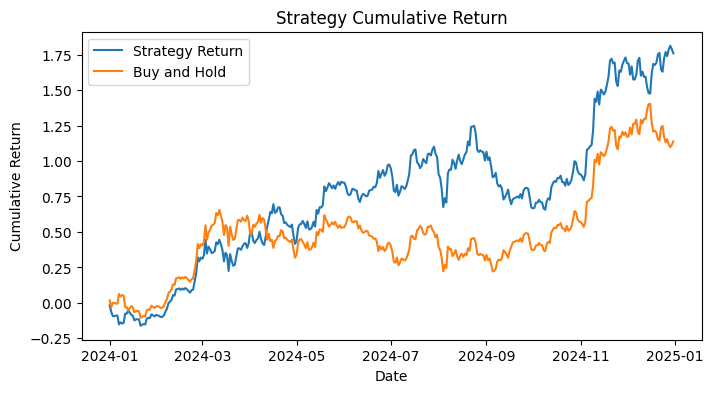

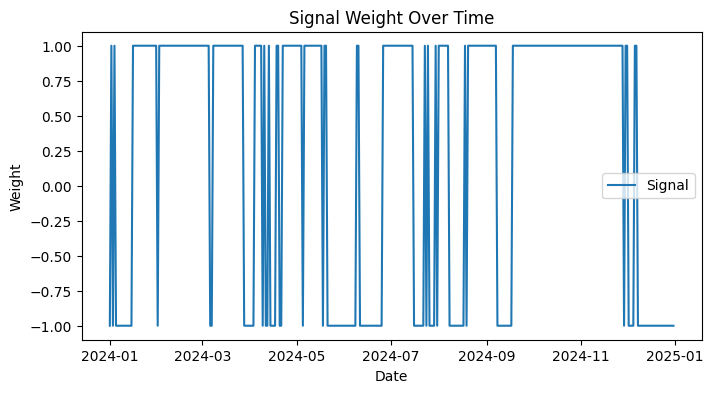

In [ ]:
model = best_rf_reg
y_pred_test = model.predict(X_test)
test_data['Predicted Close %'] = y_pred_test
test_data['signal'] = generate_signals(test_data['Predicted Close %'])

test_data.index = pd.to_datetime(test_data.index)

test_data.index = test_data.date

run_backtest(test_data)

Overall Annual Return: 91.62%
Overall Annual Sharpe Ratio: 1.7146
Maximum Drawdown: -42.83 %
Win/Loss Ratio: 1.14
Alpha: 0.53
Beta: 0.4086

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.916178    0.534337     0.408648      0.425483       1.714607


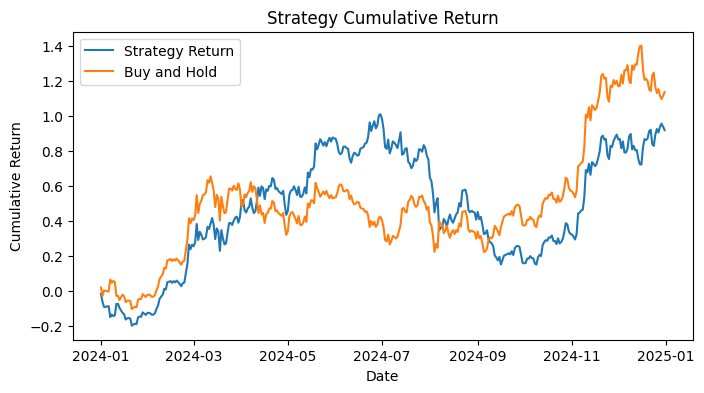

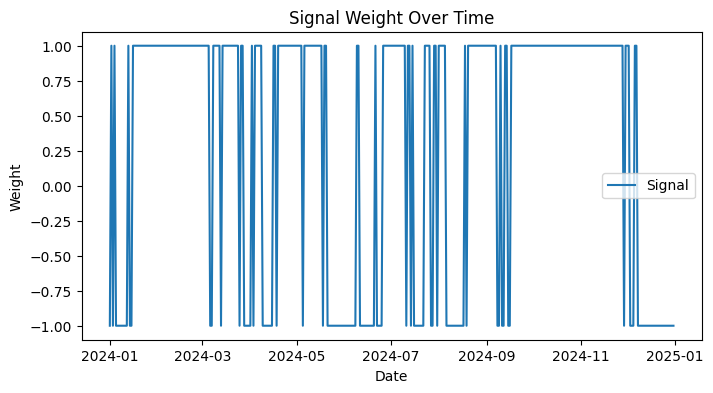

In [ ]:
model = best_xgb_reg
y_pred_test = model.predict(X_test)
test_data['Predicted Close %'] = y_pred_test
test_data['signal'] = generate_signals(test_data['Predicted Close %'])

test_data.index = pd.to_datetime(test_data.index)

test_data.index = test_data.date

run_backtest(test_data)

Overall Annual Return: 689.96%
Overall Annual Sharpe Ratio: 11.3491
Maximum Drawdown: -42.83 %
Win/Loss Ratio: 1.33
Alpha: 8.447
Beta: 0.0035

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021     137.966073    0.757263     0.113323      5.155026     182.190474
1  2022      10.070550    0.621405    -0.612757      2.081500      16.206108
2  2023       0.326139    0.442817     0.337715      0.017598       0.736509
3  2024       0.916178    0.534337     0.408648      0.425483       1.714607


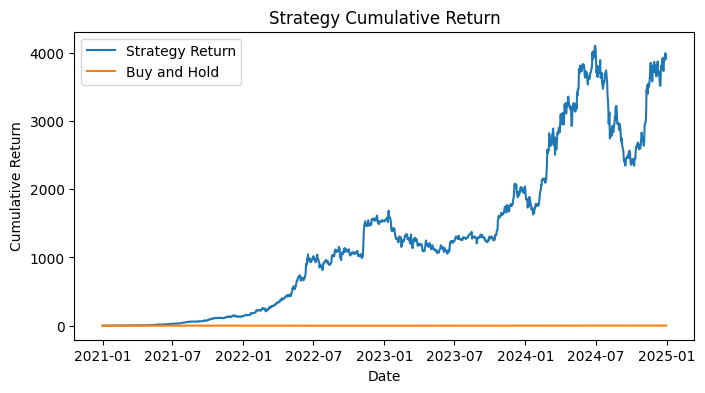

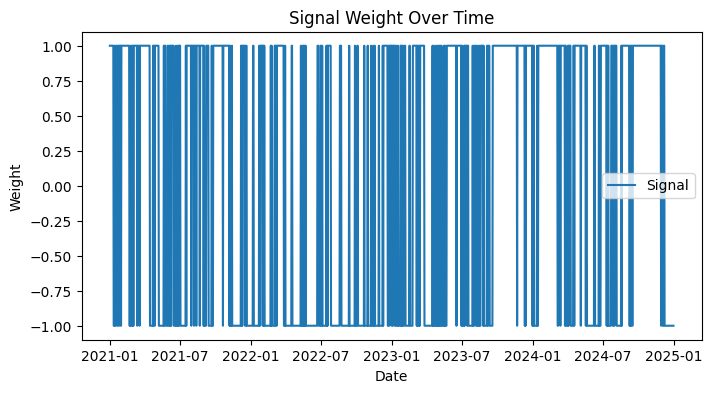

In [ ]:
  X_data = data[feature_cols]
y_pred_data = model.predict(X_data)

data['Predicted Close %'] = y_pred_data
data['signal'] = generate_signals(data['Predicted Close %'])

data.index = pd.to_datetime(data.index)

data.index = data.date

run_backtest(data)

Overall Annual Return: 1577.61%
Overall Annual Sharpe Ratio: 26.3389
Maximum Drawdown: -26.31 %
Win/Loss Ratio: 1.41
Alpha: 18.0346
Beta: 0.0979

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021     439.120407    0.732561     0.127896      6.293760     599.431926
1  2022      41.146980    0.601842    -0.337653      3.647735      68.368433
2  2023       0.559488    0.442354     0.322658      0.195752       1.264798
3  2024       1.751691    0.532531     0.516493      0.688986       3.289371


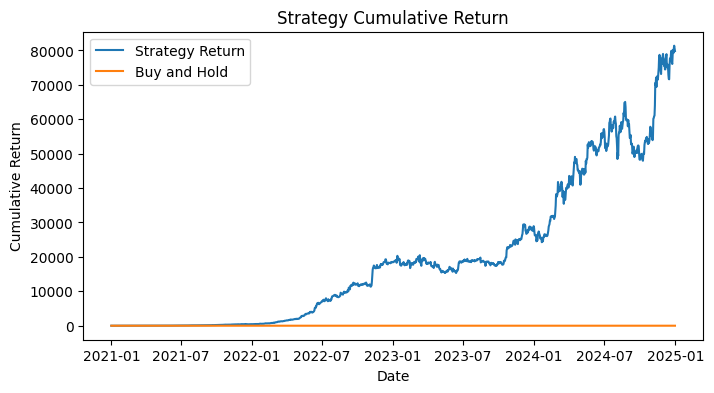

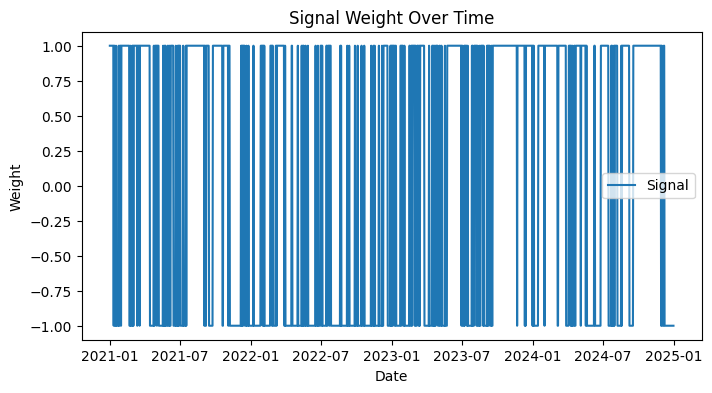

In [ ]:
model = best_rf_reg
X_data = data[feature_cols]
y_pred_data = model.predict(X_data)

data['Predicted Close %'] = y_pred_data
data['signal'] = generate_signals(data['Predicted Close %'])

data.index = pd.to_datetime(data.index)

data.index = data.date

run_backtest(data)